### Model Training

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings

In [26]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

In [27]:
df = pd.read_csv("data/stud.csv")

df.head(2)

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88


In [28]:
## creating 'average' column which will be our dependent variable...
df['average'] = (df['math_score'] + df['reading_score'] + df['writing_score'])/3

df.head(2)

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score,average
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667
1,female,group C,some college,standard,completed,69,90,88,82.333333


In [29]:
df.to_csv("data/student.csv")

In [30]:
X = df.drop(['average'],axis=1)

X.head(2)

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88


In [31]:
Y = df['average']

##### Train Test Split & Column Transformer

In [32]:
## always split before transforming to avoid data leakage...
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

In [33]:
## Column Transform...

from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_transformer = OneHotEncoder()
numerical_transformer = StandardScaler()

In [34]:
categorical_features = []
for feature in X.columns:
    if df[feature].dtype == 'O':
        categorical_features.append(feature)


numerical_features = []
for feature in X.columns:
    if df[feature].dtype != 'O':
        numerical_features.append(feature)       


print(f"There are {len(categorical_features)} Categorical Features : {categorical_features}")    
print(f"There are {len(numerical_features)} Numerical Features : {numerical_features}")

There are 5 Categorical Features : ['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch', 'test_preparation_course']
There are 3 Numerical Features : ['math_score', 'reading_score', 'writing_score']


In [35]:
preprocessor = ColumnTransformer([
    ("Standard Scaler",numerical_transformer,numerical_features),
    ("One Hot Encoder",categorical_transformer,categorical_features)  ## the number of columns will increase after performing OHE...
])

In [36]:
X_train = preprocessor.fit_transform(X_train)

X_train.shape

(800, 20)

In [37]:
X_test = preprocessor.transform(X_test)

X_test.shape

(200, 20)

##### Function to evaluate Performance Metrics & Model Training

In [38]:
def performance_metrics(test,predicted):
    mae = mean_absolute_error(test,predicted)
    mse = mean_squared_error(test,predicted)
    rmse = np.sqrt(mean_squared_error(test,predicted))
    r2 = r2_score(test,predicted)

    return mae,mse,rmse,r2

In [39]:
models = {
    "Linear Regression" : LinearRegression(),
    "Lasso Regression" : Lasso(random_state=42),
    "Ridge Regression" : Ridge(random_state=42),
    "KNN Regressor": KNeighborsRegressor(),
    "Support Vector Regression" : SVR(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest Regression": RandomForestRegressor(random_state=42),
    "XGB Regression": XGBRegressor(), 
    "CatBoost Regression": CatBoostRegressor(verbose=False,random_state=42),
    "AdaBoost Regression": AdaBoostRegressor(random_state=42)
}

In [40]:
results = []

for model_name,model in models.items():
    ## train the model...
    model.fit(X_train,Y_train)

    ## predict...
    Y_predicted = model.predict(X_test)

    ## performance metrics...
    mae,mse,rmse,r2 = performance_metrics(Y_test,Y_predicted)

    # Save results
    results.append({
        "Model": model_name,
        "Mean Absolute Error" : mae,
        "Mean Squared Error" : mse,
        "Root Mean Squared Error" : rmse,
        "R2 Score" : r2
    })


# Convert to DataFrame for easy viewing
results_df = pd.DataFrame(results)
results_df    

,Model,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,R2 Score
0,Linear Regression,1.575629e-14,4.151933e-28,2.037629e-14,1.000000
1,Lasso Regression,8.678574e-01,1.218835e+00,1.104009e+00,0.994314
2,Ridge Regression,6.601822e-03,7.560537e-05,8.695135e-03,1.000000
3,KNN Regressor,2.255000e+00,9.309756e+00,3.051189e+00,0.956571
4,Support Vector Regression,1.407630e+00,2.909811e+01,5.394266e+00,0.864260
5,Decision Tree,1.105000e+00,2.695000e+00,1.641646e+00,0.987428
6,Random Forest Regression,5.248333e-01,1.280560e+00,1.131619e+00,0.994026
7,XGB Regression,5.543794e-01,9.813724e-01,9.906424e-01,0.995422
8,CatBoost Regression,3.572100e-01,1.368646e+00,1.169892e+00,0.993615
9,AdaBoost Regression,1.557920e+00,4.681862e+00,2.163761e+00,0.978160


#### Observation : From the R2 score we can see that both Linear Regression & Ridge Regression are the best model, so lets consider Linear Regression as the preffered model.

In [41]:
linearRegression = LinearRegression()

In [42]:
linearRegression.fit(X_train,Y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [43]:
Y_predicted = linearRegression.predict(X_test)

In [44]:
r2 = r2_score(Y_test,Y_predicted)

r2

1.0

<Axes: xlabel='average'>

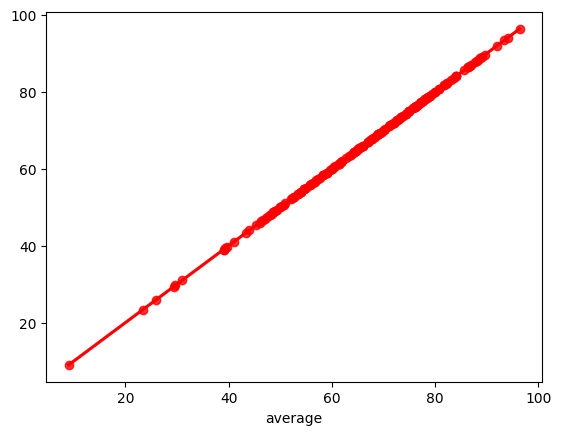

In [45]:
sns.regplot(x=Y_test,y=Y_predicted,color='red')

In [46]:
## After performing Catboost a 'catboost_info' folder will be created...this should not be pushed to github...add it to gitignore...